**A few warnings:**
- For simplicity, we will only be getting Python users with star counts greater than 0. This is because there are 32,411,626 users in the users table, so it would make the tables gigantic and percentage cutoffs very miniscule. This may slightly affect the distribution, but we should still be able to get a good analysis from it. 

- I removed some columns that are extraneous and unnecessary. For example, I removed `sha, created_at` from `commits` because I don't think we'll be looking up the `sha` or need the date. After removing them, the query processed *65 LESS GB*. Not too bad huh?

- The `followers` table is super confusing because `follower_id` means whoever `user_id` is following. NOT a follower of `user_id`. Hence why I think it's stupid why it wasn't called `following_id`.

- The `organization_members` table is inaccurate past Nov 2015 because "organizations can now select whether membership information is revealed to external parties".

# Run this entire section for access to functions / variables

**Always run this to get access to all required libraries.**

In [ ]:
!pip install PyGithub radon

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import matplotlib.ticker as mtick
import re
import copy
import random

from google.colab import drive, files
from collections import OrderedDict
from radon.complexity import cc_rank, cc_visit, average_complexity
from radon.raw import analyze
from radon.metrics import h_visit
from github import Github

**Environment variables you need to configure for your own use.**

In [ ]:
drive.mount('/content/drive')
fileloc = '/content/drive/My Drive/189L/189L Project/data/'
project_id = 'spencer189lproject'

Mounted at /content/drive


**Global constants you can modify.**

In [ ]:
PERCENTILES = [.1, 1, 5, 10, 15, 25, 50, 100] 
SAMPLE_SIZE = 1280  # WARNING: .1% bin only has 160 users, so SAMPLE_SIZE cant be too high. Or you can make the .1% 'bin' bigger.

## Useful functions for I/O

In [ ]:
def loadData(name):
  with open(fileloc + 'pkl/' + name + '.pkl', 'rb') as file:
    obj = pickle.load(file)
  return obj

def saveData(obj, name):
  with open(fileloc + 'pkl/' + name + '.pkl', 'wb') as file:
    pickle.dump(obj, file)

# Random User Selection

Obtain the amount of users in each percentile (number of users in a percentile based on star count). You can modify percentiles, which would change the bins that users are placed in (ex: 1-25%, 25-100%). Also note that technically they aren't 'percentiles', but rather exclusive ranges. For example, 5% in this case represents a bin ranging from 1% to 5%. 'Bin' would be a more accurate term but I feel it isn't very descriptive compared to 'percentile'. LMK if there's a better descriptive term.

Get the users from each bin, `users_bin`. Then, create a list of bins called `users_bins` that we can use for future queries. Note we sample `SAMPLE_SIZE` from each bin because we don't want a bunch of gigantic dataframes. 1000 should be statistically significant.

In [ ]:
with open(fileloc + 'pkl/star_count.pkl', 'rb') as file:
  star_count = pickle.load(file)
star_count

,login,stars
id,,
796,kennethreitz,40087
3569,mitsuhiko,34739
2574738,vinta,23850
73244,nvbn,23822
3752431,donnemartin,21311
...,...,...
387247,dan-boa,1
1127506,lucasdgf,1
1954472,TheTourer,1


For my own future reference, I realized that it would've been easier to make the percentile it's own column inside the dataframe instead of making a percentile dictionary. But too late now lol

In [ ]:
percentages = [str(percentile) + '%' for percentile in PERCENTILES]
num_users = np.round(np.array(PERCENTILES) / 100 * len(star_count)).astype(int)

users_bins = OrderedDict()
for i in range(len(PERCENTILES)):
  bin_left_edge = num_users[i - 1] if i != 0 else 0
  bin_right_edge = num_users[i]
  users_bin = star_count.iloc[bin_left_edge:bin_right_edge, :]

  # Sample n amount so we dont have a gigantic dataframe (otherwise we would have ~150,000)
  users_bin = users_bin.sample(SAMPLE_SIZE // len(PERCENTILES), random_state=8)
  users_bins[percentages[i]] = users_bin.sort_values(by='stars', ascending=False)

users_bins

OrderedDict([('0.1%',                 login  stars
              id                          
              796      kennethreitz  40087
              3569        mitsuhiko  34739
              2574738         vinta  23850
              73244            nvbn  23822
              3752431   donnemartin  21311
              ...               ...    ...
              11682       kstenerud   2072
              428875     kovidgoyal   2069
              980415         dbader   2067
              18406          mrjoes   2066
              122415         amjith   2060
              
              [160 rows x 2 columns]), ('1%',                login  stars
              id                         
              2072970    worldveil   1929
              665521    rbgirshick   1822
              56642        posativ   1704
              345746        mmin18   1630
              985918    gunthercox   1584
              ...              ...    ...
              1769467    fniephaus    288
        

In [ ]:
median_star_count = [int(np.median(bin.stars)) for percent, bin in users_bins.items()]

percentile_info = pd.DataFrame({
    'percent': percentages,
    'num_users': num_users,
    'median_star_count': median_star_count
})

percentile_info

,percent,num_users,median_star_count
0,0.1%,160,3165
1,1%,1603,507
2,5%,8015,86
3,10%,16030,25
4,15%,24046,13
5,25%,40076,6
6,50%,80152,2
7,100%,160304,1


### Data Loading

Initially, you had to use BigQuery to retrieve the tables. However, I already saved the queried tables into a data folder, so you don't have to do it again! Otherwise, we'll start losing money on resources 😅.

In [ ]:
commit_comments = loadData('commit_comments')
commits = loadData('commits')
followers = loadData('followers_follower_id')
following = loadData('followers_user_id')
issue_comments = loadData('issue_comments')
issue_events = loadData('issue_events')
issues_reporters = loadData('issues_reporter_id')
issues_assignees = loadData('issues_assignee_id')
organization_members = loadData('organization_members')
project_members = loadData('project_members')
projects = loadData('projects')
pull_request_comments = loadData('pull_request_comments')
pull_request_history = loadData('pull_request_history')
watchers = loadData('watchers')

# EDA & Graphs

I just realized that the median graphs are redundant because boxplots contain the medians anyways.

### Run this before plotting any graphs

In [ ]:
tables = [commit_comments, commits, followers, following, issue_comments, issue_events, issues_reporters, issues_assignees, organization_members, project_members, projects, pull_request_comments, pull_request_history, watchers]
titles = ['Commit Comments', 'Commits', 'Followers', 'Following', 'Issue Comments', 'Issue Events', 'Issues Reported', 'Issues Assigned', 'Organization Membership', 'Project Membership', 'Projects Owned', 'Pull Request Comments', 'Pull Request History', 'Projects Starred']

## Boxplot of Fact for Each Percentile

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

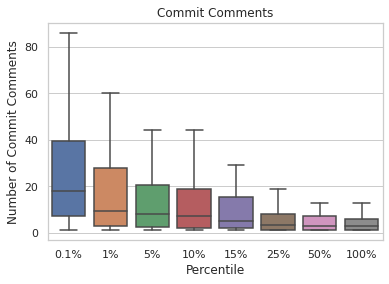

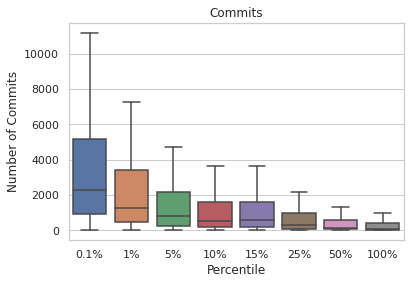

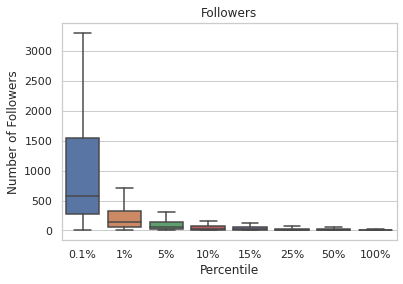

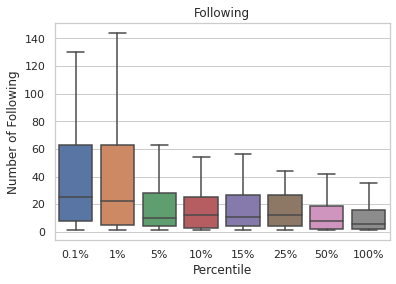

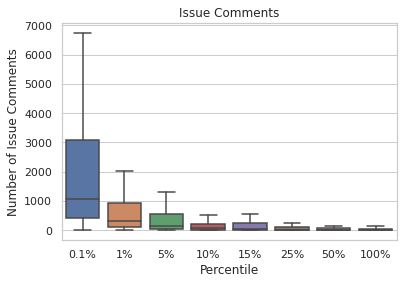

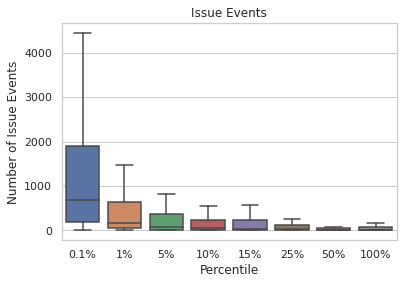

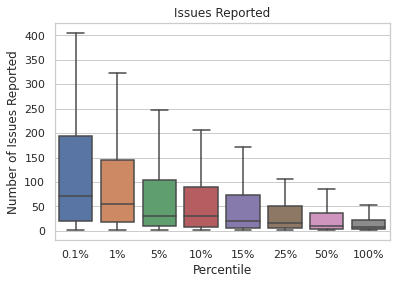

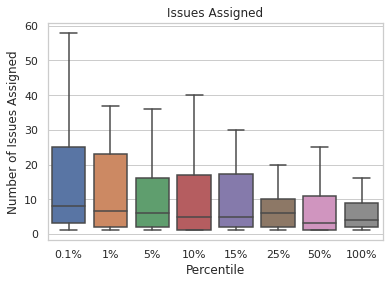

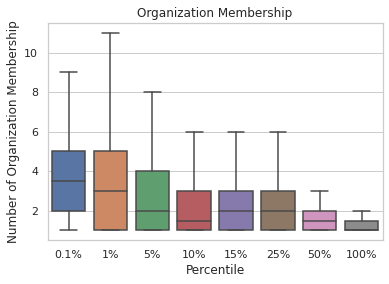

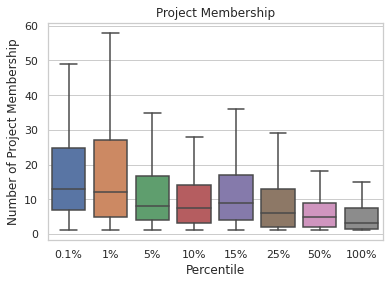

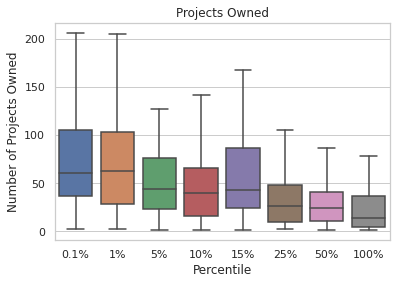

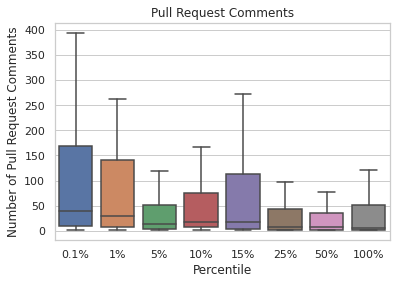

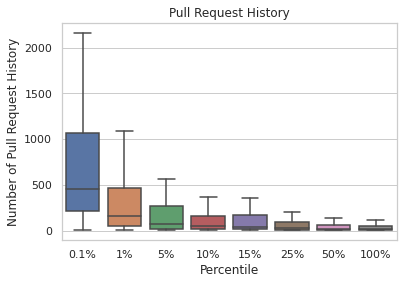

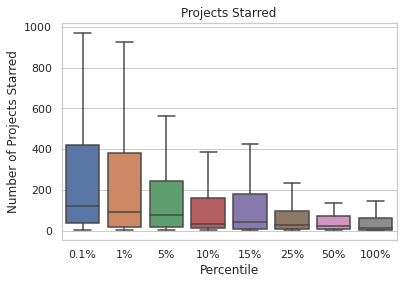

In [ ]:
import seaborn as sns

def boxplotFacts(tables, titles):
  sns.set_theme(style="whitegrid")

  for table, title in zip(tables, titles):
    facts = OrderedDict()
    for percent, bin in table.items():
      facts[percent] = bin.index.value_counts().to_numpy()

    plt.figure()
    ax = sns.boxplot(data=list(facts.values()), showfliers=False)
    plt.title(title)
    plt.xlabel('Percentile')
    plt.ylabel(f'Number of {title}')
    ax.set_xticklabels(facts.keys())

    plt.savefig(title + ' boxplot.png')
    files.download(title + ' boxplot.png') 

boxplotFacts(tables, titles)

## Median Number of Fact for Each Percentile

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

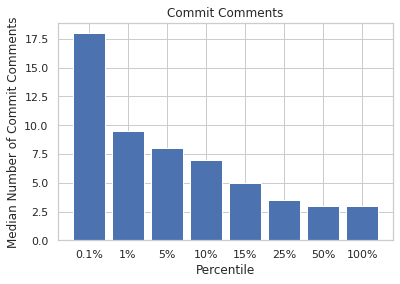

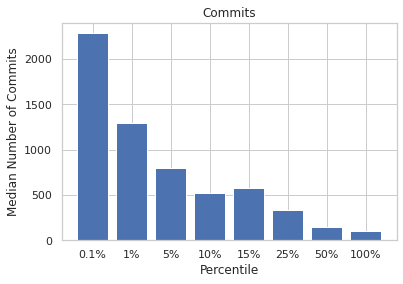

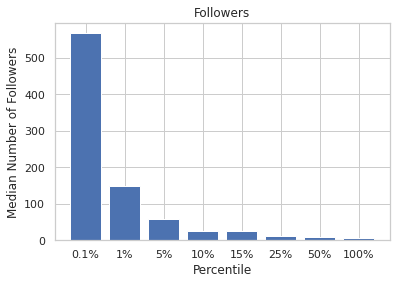

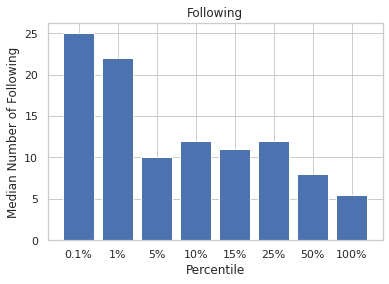

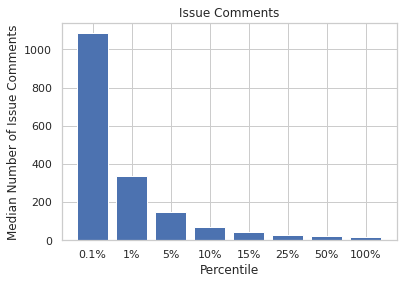

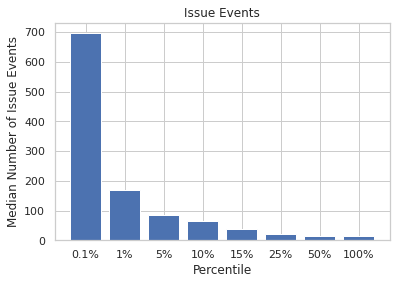

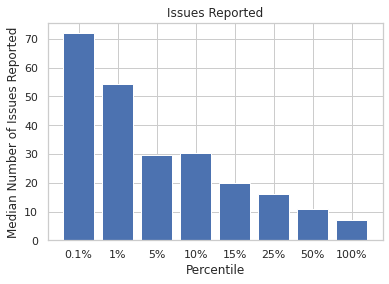

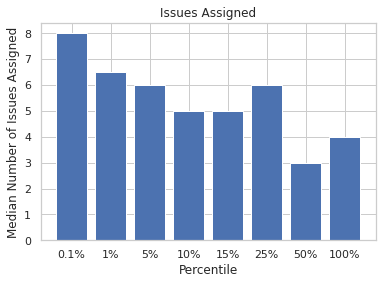

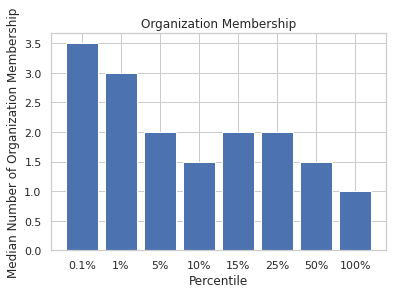

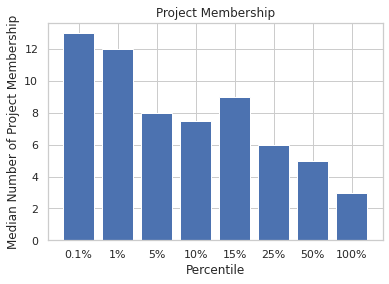

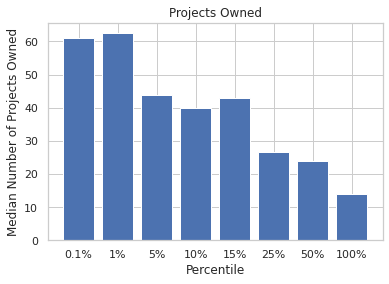

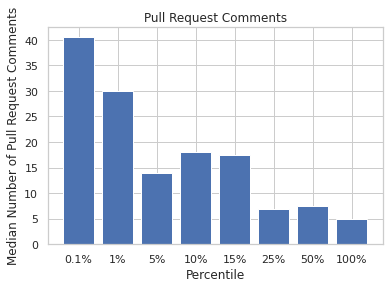

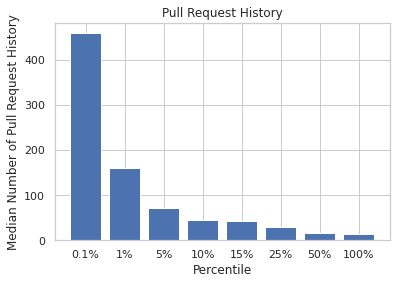

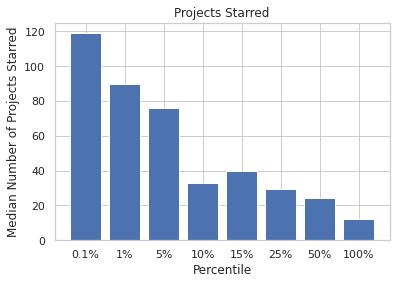

In [ ]:
def medianNumOfFacts(tables, titles):
  sns.set_theme(style="whitegrid")

  for table, title in zip(tables, titles):
    median_facts = OrderedDict()
    for percent, bin in table.items():
      median_facts[percent] = np.median(bin.index.value_counts())

    plt.figure()
    plt.bar(median_facts.keys(), median_facts.values())
    plt.title(title)
    plt.xlabel('Percentile')
    plt.ylabel(f'Median Number of {title}')

    plt.savefig(title + ' Median.png')
    files.download(title + ' Median.png') 

medianNumOfFacts(tables, titles)

## Percent Change of Fact for Each Percentile Against the 100% Percentile

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

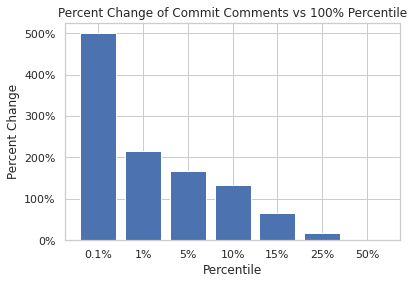

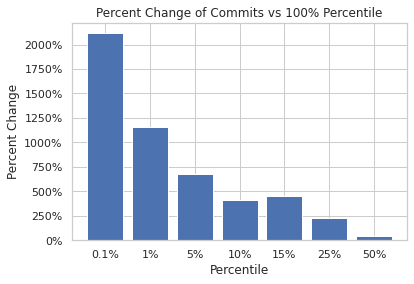

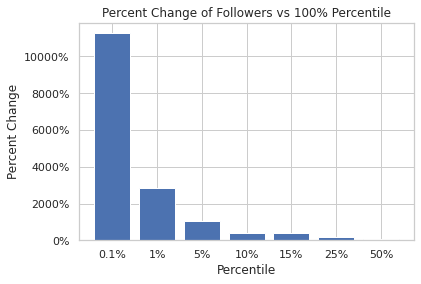

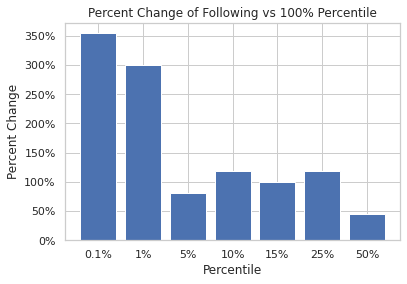

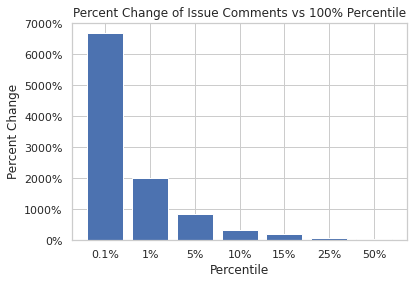

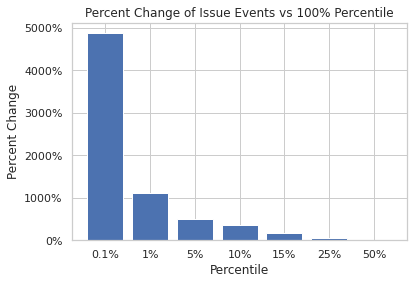

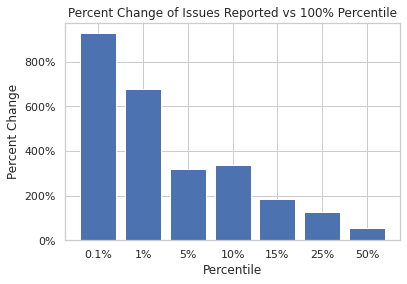

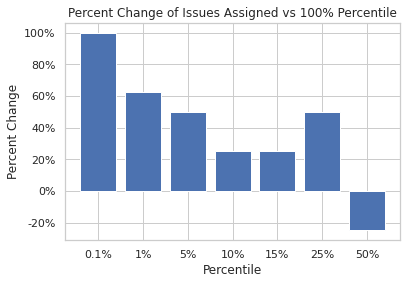

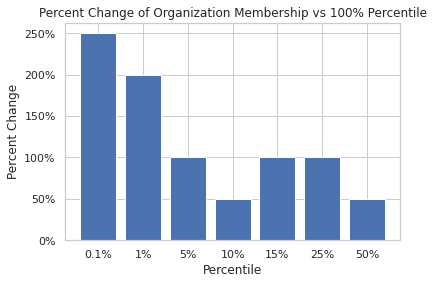

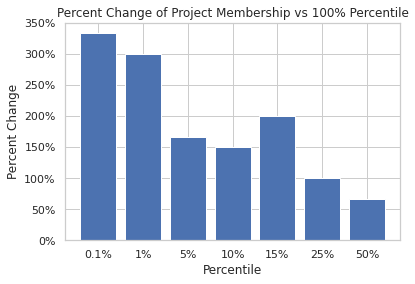

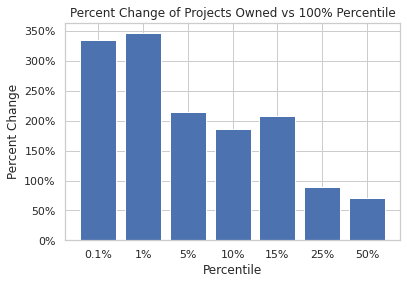

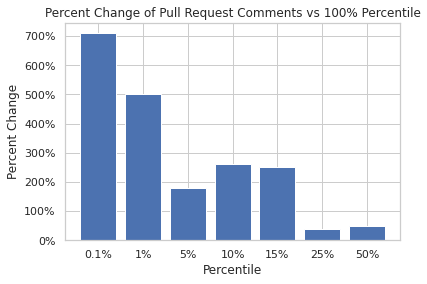

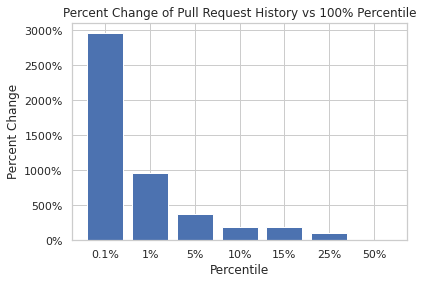

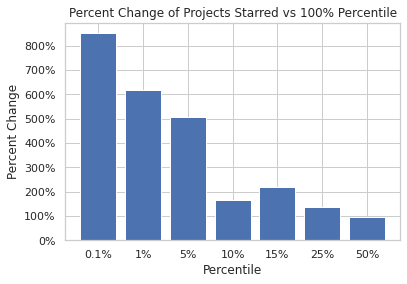

In [ ]:
def percentChangeOfFacts(tables, titles):
  sns.set_theme(style="whitegrid")

  for table, title in zip(tables, titles):
    median_val_100percent = np.median(table['100%'].index.value_counts())
    percent_change = OrderedDict()

    for percent, bin in table.items():
      if percent != '100%':
        median_val = np.median(bin.index.value_counts())
        percent_change[percent] = (median_val - median_val_100percent) / median_val_100percent * 100

    fig, ax = plt.subplots()
    plt.bar(percent_change.keys(), percent_change.values())
    plt.title(f'Percent Change of {title} vs 100% Percentile')
    plt.xlabel('Percentile')
    plt.ylabel('Percent Change')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    plt.savefig(title + ' Percent Change.png')
    files.download(title + ' Percent Change.png') 

percentChangeOfFacts(tables, titles)

# Code Analysis with Radon

Watch out for GitHub's API rate limit! I can only examine 166 users / hour. I might just automate it so this colab does it every hour. But for now, we're just gonna have to manually do this. Also, try to use Basic Authentication. You can increase the requests limit from 60 to 5000! Finally, we shouldn't try to examine every user that we selected. Instead we should try to randomly sample users. That should still be a good enough approximation.

### Check how many requests you have left.
Replace 'slampham:{token}' with your own {username}:{token}

In [ ]:
# My token: 1c299aa4cfdbf17551549fbb55ab100023fd35db
!curl -u "slampham:1c299aa4cfdbf17551549fbb55ab100023fd35db" -H "Accept: application/vnd.github.v3+json" https://api.github.com/rate_limit

{
  "resources": {
    "core": {
      "limit": 5000,
      "used": 3936,
      "remaining": 1064,
      "reset": 1608271082
    },
    "search": {
      "limit": 30,
      "used": 0,
      "remaining": 30,
      "reset": 1608268040
    },
    "graphql": {
      "limit": 5000,
      "used": 0,
      "remaining": 5000,
      "reset": 1608271580
    },
    "integration_manifest": {
      "limit": 5000,
      "used": 0,
      "remaining": 5000,
      "reset": 1608271580
    },
    "source_import": {
      "limit": 100,
      "used": 0,
      "remaining": 100,
      "reset": 1608268040
    },
    "code_scanning_upload": {
      "limit": 500,
      "used": 0,
      "remaining": 500,
      "reset": 1608271580
    }
  },
  "rate": {
    "limit": 5000,
    "used": 3936,
    "remaining": 1064,
    "reset": 1608271082
  }
}


## Find real (non-deleted, non-forked) projects

For simplicity, I call these `real projects`. Later on, I also drop real projects that are Python 2 just because I can't figure out how to configure it to deal with that type of code :L.

In [ ]:
real_projs = OrderedDict()
for percent, bin in projects.items():
  real_projs[percent] = bin.query("language == 'Python' & forked_from == 'NaN' & deleted == 0").reset_index().set_index('id')

real_projs['0.1%']  # Example of real projects in top percentile

,owner_id,url,language,forked_from,deleted,login,stars
id,,,,,,,
3227233,11304,https://api.github.com/repos/Miserlou/HitStarter,Python,NaN,0,Miserlou,2536
3237482,6569,https://api.github.com/repos/jezdez-archive/dr...,Python,NaN,0,jezdez,2992
3247294,190763,https://api.github.com/repos/emre/redis-router,Python,NaN,0,emre,2502
3248889,131414,https://api.github.com/repos/andrewgodwin/kuge...,Python,NaN,0,andrewgodwin,2143
3275064,351810,https://api.github.com/repos/nlintz/SigsysFinal,Python,NaN,0,nlintz,2426
...,...,...,...,...,...,...,...
132714157,197092,https://api.github.com/repos/PeterDing/hearken,Python,NaN,0,PeterDing,2093
132748310,1295135,https://api.github.com/repos/miguelgrinberg/mi...,Python,NaN,0,miguelgrinberg,6750
132795859,796,https://api.github.com/repos/kennethreitz/requ...,Python,NaN,0,kennethreitz,40087


We end up loading the real projects anyway. I just showed the code above for reference and understanding.

In [ ]:
real_projs = loadData('real_projs')

## Files Collection & Metric Analysis

1. Find which percentile group we want (ex: '5%') 
2. Get specific metric (ex: 'difficulty')

In [ ]:
raw_metrics = { 'loc': [], 'lloc': [], 'sloc': [], 'comments': [], 'multi': [], 'blank': [], 'single_comments': [] }
halstead = { 'vocabulary': [], 'length': [], 'calculated_length': [], 'volume': [], 'difficulty': [], 'effort': [], 'time': [], 'bugs': [] }

metrics = OrderedDict({
  'complexity': [],
  'loc': [], 'lloc': [], 'sloc': [], 'comments': [], 'multi': [], 'blank': [], 'single_comments': [],
  'vocabulary': [], 'length': [], 'calculated_length': [], 'volume': [], 'difficulty': [], 'effort': [], 'time': [], 'bugs': [],
})

projs_metrics = OrderedDict()
for percent in real_projs.keys():
  projs_metrics[percent] = copy.deepcopy(metrics)

Again, the above code is just for reference. We already created the metrics object so we just load it.

In [ ]:
projs_metrics = loadData('projs_metrics')

In [ ]:
def projMetrics(tree):
  files_complexity = []
  files_raw_metrics = { 'loc': [], 'lloc': [], 'sloc': [], 'comments': [], 'multi': [], 'blank': [], 'single_comments': [] }
  files_halstead = { 'vocabulary': [], 'length': [], 'calculated_length': [], 'volume': [], 'difficulty': [], 'effort': [], 'time': [], 'bugs': [] }

  for element in tree.tree:
    python_file = re.search("\.py$", element.path)
    
    if python_file:  # If element in tree is a python file
      file_content = repo.get_contents(element.path)  # We decode because code are saved encoded
      code = file_content.decoded_content.decode() 

      blocks = cc_visit(code)  # metric 1
      raw_metrics = analyze(code)  # metric 2
      halstead = h_visit(code).total  # metric 3

      # Ignore if file literally has 0 logical lines, vocab, or length (essentially useless python file)
      if raw_metrics.lloc == 0 or halstead.vocabulary == 0 or halstead.length == 0 or not blocks:
        continue

      for key in files_raw_metrics.keys():
        files_raw_metrics[key].append(getattr(raw_metrics, key))

      for key in files_halstead.keys():
        files_halstead[key].append(getattr(halstead, key))

      complexity = average_complexity(blocks)
      if blocks:  # Sometimes radon cannot read python files. So we make sure it contains blocks before appending
        files_complexity.append(complexity)

  # Get mean metric of all files
  files_complexity = np.mean(files_complexity)
  for key, vals in files_raw_metrics.items():
    files_raw_metrics[key] = np.mean(vals)
  for key, vals in files_halstead.items():
    files_halstead[key] = np.mean(vals)

  return files_complexity, files_raw_metrics, files_halstead

## GitHub API Calls & Project Metric Analysis

Unfortunately I couldn't find a way to make Radon work with Python2 correctly. So for now we just ignore them.

In [ ]:
from github import RateLimitExceededException, GithubException

g = Github('1c299aa4cfdbf17551549fbb55ab100023fd35db')  # Passing my token to parameter ('1c299aa4cfdbf17551549fbb55ab100023fd35db')

for _ in range(1000):  # Go until the API stops us
  percent = random.choice(list(projs_metrics))  # Choose random percentile
  random_proj = real_projs[percent].sample()    # Choose random project
  api_url = random_proj.url.values[0]           # Get url
  
  regex = re.search(r"https://api\.(github\.com/)repos/(.*/.*)", api_url)
  username_repo = regex.group(2)

  try:
    repo = g.get_repo(username_repo)
    branch = repo.get_branch(branch='master')
    sha = branch.commit.sha
    tree = repo.get_git_tree(sha, recursive=True)

    files_complexity, files_raw_metrics, files_halstead = projMetrics(tree)

    # Append mean value of project to each metric (if it exists)
    if not np.isnan(files_complexity):  # Append only if we have a complexity
      projs_metrics[percent]['complexity'].append(files_complexity)
    
    for key, val in files_raw_metrics.items():
      if not np.isnan(val):  # Append only if raw_metric exists
        projs_metrics[percent][key].append(val)
    
    for key, val in files_halstead.items():
      if not np.isnan(val):  # Append only if halstead exists
        projs_metrics[percent][key].append(val)

    saveData(projs_metrics, 'projs_metrics')

  except RateLimitExceededException as err:
    print(err)
    break
  except Exception as err:  # Remove proj if syntax errors because it can't process Python2, or git problems with proj
    print(err)
    real_projs[percent] = real_projs[percent].drop(random_proj.index[0])
    saveData(real_projs, 'real_projs')

## Projects Metric Graphs

## Metrics Median

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

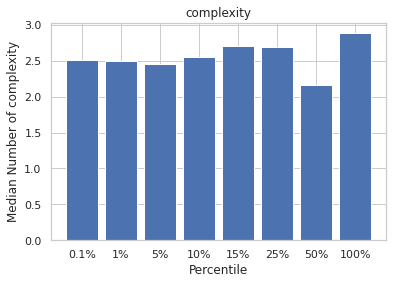

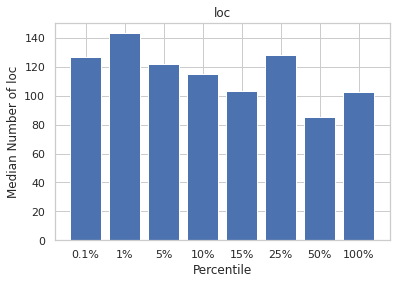

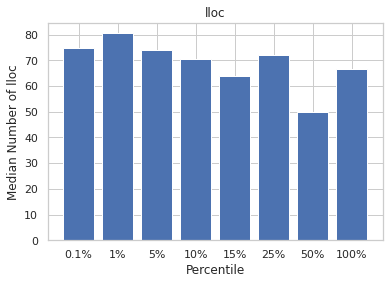

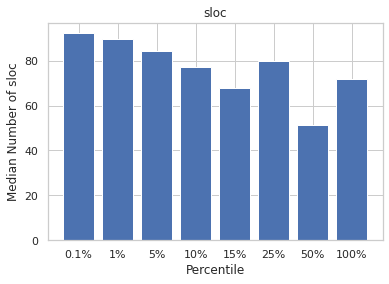

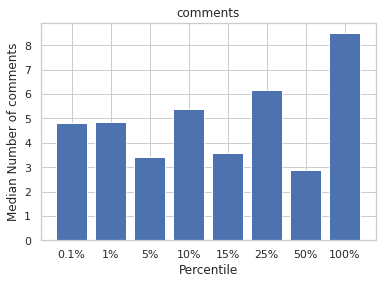

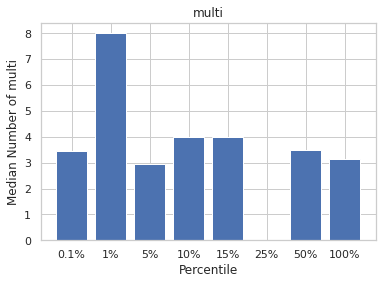

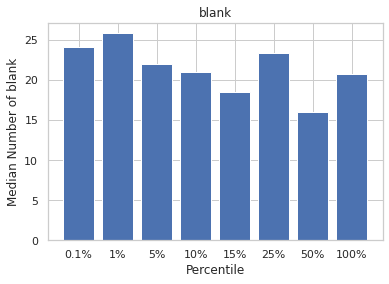

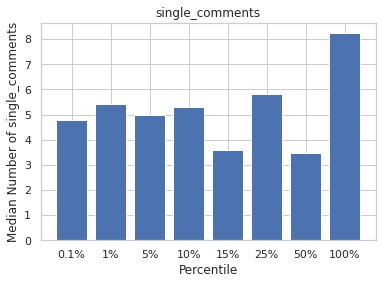

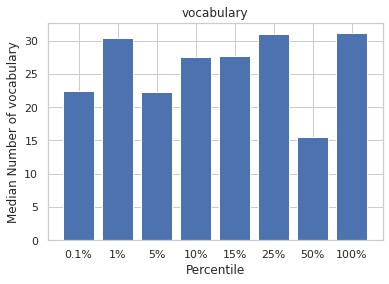

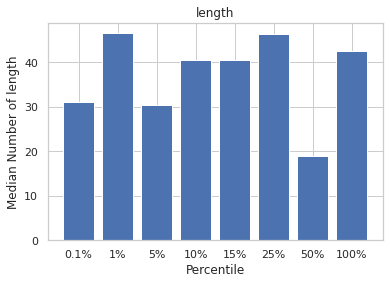

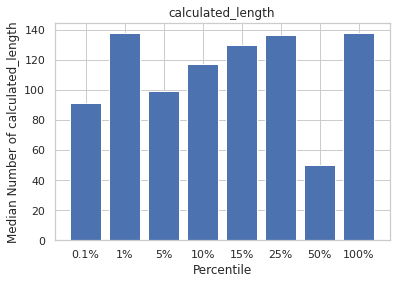

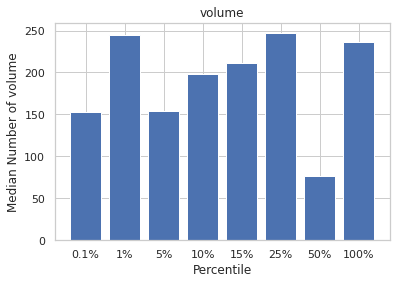

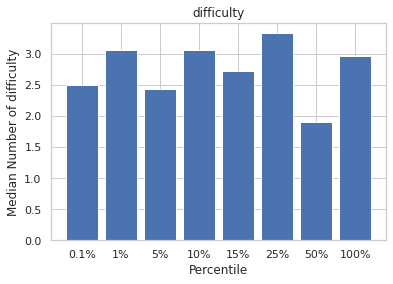

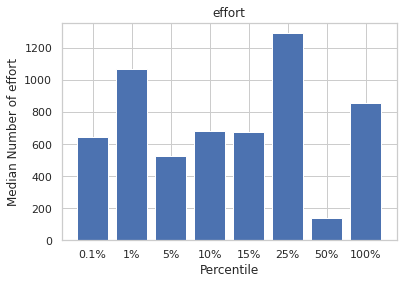

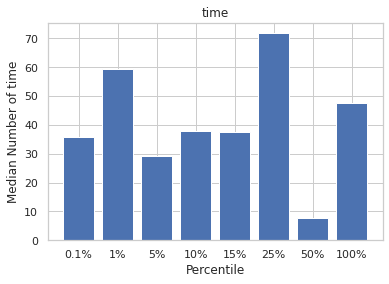

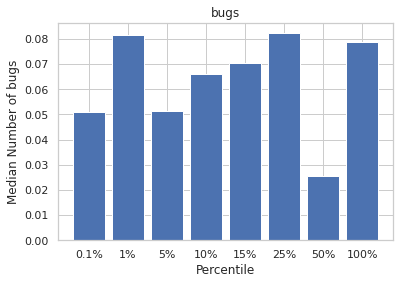

In [ ]:
def plotMedianMetric(projs_metrics):
  sns.set_theme(style="whitegrid")
  metrics = projs_metrics['1%'].keys()

  for metric in metrics:
    median_metric = OrderedDict()

    for percent in projs_metrics.keys():
      median_metric[percent] = np.median(projs_metrics[percent][metric])

    plt.figure()
    plt.bar(median_metric.keys(), median_metric.values())
    plt.title(metric)
    plt.xlabel('Percentile')
    plt.ylabel(f'Median Number of {metric}')

    plt.savefig(metric + ' median.png')
    files.download(metric + ' median.png')

plotMedianMetric(projs_metrics)

## Metrics Boxplot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

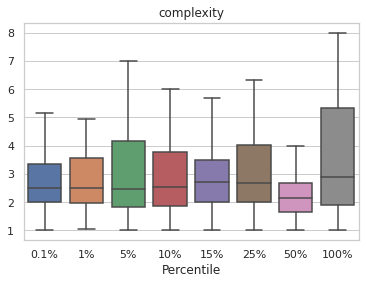

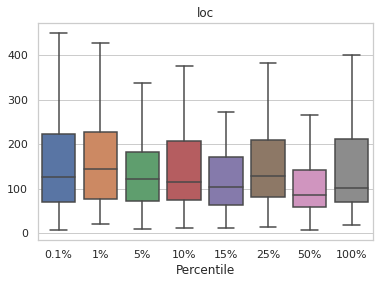

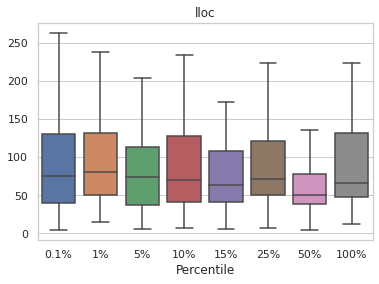

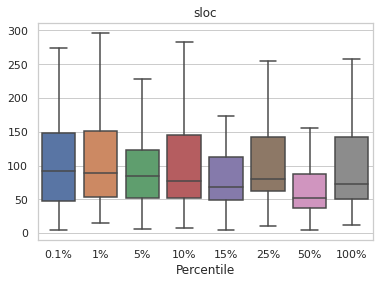

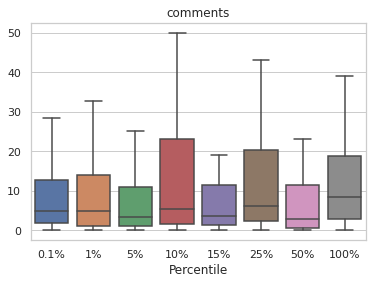

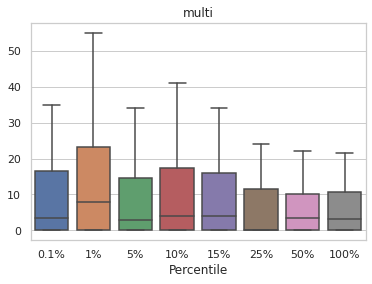

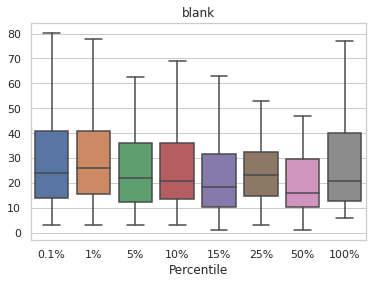

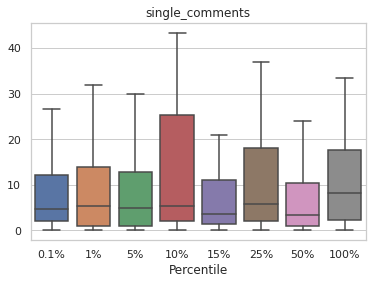

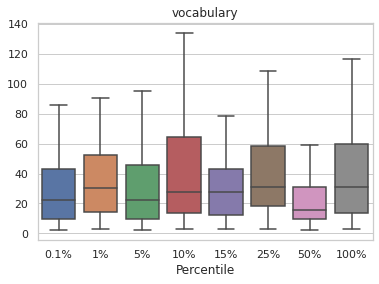

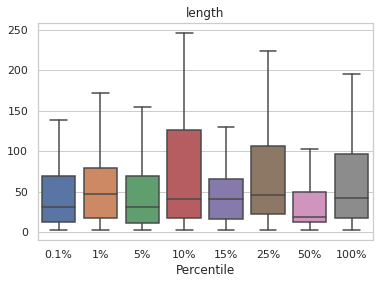

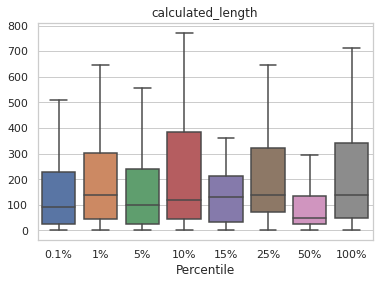

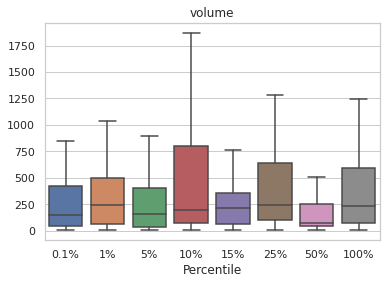

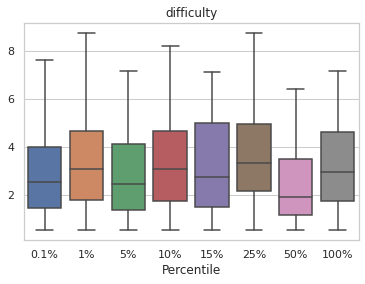

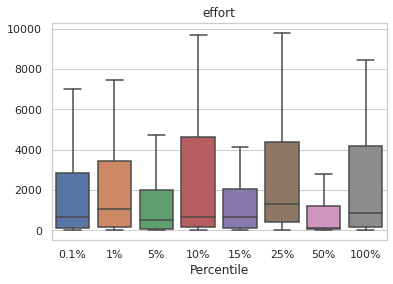

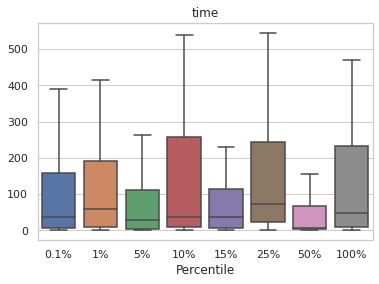

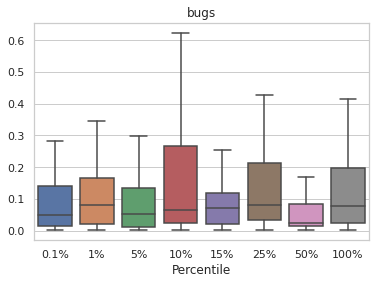

In [ ]:
import seaborn as sns

def boxplotMetrics(projs_metrics):
  sns.set_theme(style="whitegrid")

  for metric, bin in projs_metrics['1%'].items():
    metric_vals = []
    
    for percent in projs_metrics.keys():
      metric_vals.append(projs_metrics[percent][metric])

    plt.figure()
    ax = sns.boxplot(data=metric_vals, showfliers=False)
    plt.title(metric)
    plt.xlabel('Percentile')
    ax.set_xticklabels(projs_metrics.keys())

    plt.savefig(metric + ' boxplot.png')
    files.download(metric + ' boxplot.png')

boxplotMetrics(projs_metrics)

# Data Gathering

**WARNING: only run this if, for some reason, you can't retrieve the specific queries from the data folder using pickle. We don't want to use all our resources!**

In [ ]:
star_count = pd.io.gbq.read_gbq("""
  SELECT u.login, u.id, COUNT(*) as stars
  FROM ghtorrent-bq.ght.watchers w, ghtorrent-bq.ght.projects p, ghtorrent-bq.ght.users u
  WHERE 
    w.repo_id = p.id AND
    p.language = "Python" AND
    p.owner_id = u.id AND
    u.type = "USR"
  GROUP BY u.login, u.id
  ORDER BY stars desc
  """, project_id=project_id, dialect='standard').set_index('id')

star_count.to_csv(fileloc + 'csv/star_count.csv', index=False)

In [ ]:
all_selected_users = pd.concat(users_bins.values())

def query(table, user_label, excepts=[]):
  query_string = "SELECT * "
  
  if excepts: 
    query_string += f"EXCEPT ({', '.join(f'{field}' for field in excepts)}) "

  query_string += f"""
    FROM
      `ghtorrentmysql1906.MySQL1906.{table}`
    WHERE
      {user_label} IN ({', '.join(f'{user}' for user in all_selected_users.index.to_list())})
    """

  return pd.io.gbq.read_gbq(query_string , project_id=project_id, dialect='standard')

def queryUsersBins(table, user_label, excepts):
  df = query(table, user_label, excepts)
  df.to_csv(fileloc + 'csv/' + table + '.csv', index=False)
  
  df_bins = OrderedDict()
  for percent, bin in users_bins.items():
    query_bin = df[df[user_label].isin(bin.index)]
    df_bins[percent] = query_bin.merge(all_selected_users, how='left', left_on=user_label, right_index=True).set_index(user_label)

  with open(fileloc + 'pkl/' + table + '.pkl', 'wb') as file:  # Save files
    pickle.dump(df_bins, file)

  return df_bins

In [ ]:
commit_comments = queryUsersBins('commit_comments', 'user_id', ['id', 'body', 'line', 'position', 'comment_id', 'created_at'])
commits = queryUsersBins('commits', 'author_id', ['sha', 'commiter_id', 'created_at'])
issue_comments = queryUsersBins('issue_comments', 'user_id', ['comment_id', 'created_at'])
issue_events = queryUsersBins('issue_events', 'actor_id', ['event_id', 'action_specific', 'created_at'])
organization_members = queryUsersBins('organization_members', 'user_id', ['created_at'])
project_members = queryUsersBins('project_members', 'user_id', ['created_at', 'ext_ref_id'])
projects = queryUsersBins('projects', 'owner_id', ['name', 'description', 'created_at', 'updated_at', 'unknown_column'])
pull_request_comments = queryUsersBins('pull_request_comments', 'user_id', ['comment_id', 'position', 'body', 'created_at'])
pull_request_history = queryUsersBins('pull_request_history', 'actor_id', ['created_at'])
watchers = queryUsersBins('watchers', 'user_id', ['created_at'])

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=ccuHttwVdyqNA1YtjFyNkbbC4NIG85&prompt=consent&access_type=offline
Enter the authorization code: 4/1AY0e-g6pz3zlOG7R7KKUFdpXzFQ7yRErJe-GQdvKuyab3zCtJX6Tbz88qIA


## Special Queries for 2 User Labels

This section is super confusing to read, but essentially this is an extra query for tables `issues, followers`, where there are two user labels: `reporter_id, assignee_id` and `user_id, follower_id`. Kind of a pain in the ass to write because I had to write extra conditions and stuff, but just know it works (I hope :L lmao)

In [ ]:
def query2UserLabels(table, user_labels, excepts=[]):
  query_string = "SELECT * "
  
  if excepts: 
    query_string += f"EXCEPT ({', '.join(f'{field}' for field in excepts)}) "

  formatted_users_string = f"({', '.join(f'{user}' for user in all_selected_users.index.to_list())})"

  query_string += f"""
    FROM
      `ghtorrentmysql1906.MySQL1906.{table}`
    WHERE
      {user_labels[0]} IN {formatted_users_string} OR {user_labels[1]} IN {formatted_users_string}
    """

  return pd.io.gbq.read_gbq(query_string , project_id=project_id, dialect='standard')

def queryUsersBins2UserLabels(table, user_labels, excepts):
  df = query2UserLabels(table, user_labels, excepts)
  df.to_csv(fileloc + 'csv/' + table + '.csv', index=False)

  tables = []

  for user_label in user_labels:
    df_bins = OrderedDict()
    for percent, bin in users_bins.items():
      query_bin = df[df[user_label].isin(bin.index)]
      df_bins[percent] = query_bin.merge(all_selected_users, how='left', left_on=user_label, right_index=True).set_index(user_label)

    with open(fileloc + 'pkl/' + table + '_' + user_label + '.pkl', 'wb') as file:  # Save files
      pickle.dump(df_bins, file)

    tables.append(df_bins)

  return tables[0], tables[1]

In [ ]:
follows, followers = queryUsersBins2UserLabels('followers', ['user_id', 'follower_id'], ['created_at'])
issue_reporters, issue_assigned = queryUsersBins2UserLabels('issues', ['reporter_id', 'assignee_id'], ['pull_request', 'created_at'])